# TODO scrape any car data from ss.com
* clean up prices as numerics
* group by make and model
* plot the data - pricing for sure
* if you do more advanced analysis that also could be used for the final project

* for those who want scraping part of final project
* scrape data from somewhere else - maybe Lithuanian ss.com or wikipedia?

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import unicodedata
import matplotlib.pyplot as plt
import numpy as np

# Get URL and scrape the data, save to CSV file 

In [2]:
url = "https://www.ss.com/en/transport/cars/audi/"
url


'https://www.ss.com/en/transport/cars/audi/'

In [3]:
req = requests.get(url)  #extracting the html
req.status_code

200

In [4]:
soup = BeautifulSoup(req.text, 'lxml') 
soup.title

<title>SS.COM Cars - Audi, Prices - Advertisements</title>

In [5]:
# lets combine the above cells into a function which will always get us columns
def getColList(soup):
    column_list = ["description","url"] # we decided to that we need these two column names no matter the html
    headline = soup.find("tr", {"id":"head_line"}) #this will work as long as html has a table row with id head_line
    headtds = headline.find_all("td")
    headcolumns = [el.text for el in headtds[1:]]  # this will get all column names starting with 2nd in HTML
    column_list += headcolumns
    return column_list

In [6]:
column_names = getColList(soup)
column_names  # to be used later when creating our table

['description', 'url', 'Model', 'Year', 'Volume', 'Run', 'Price']

In [7]:
def getRowList(soup):
    trows = soup.find_all('tr')
    aprows = [row for row in trows if row.get('id',"").startswith("tr_") and not row.get('id',"").startswith("tr_bnr") ]
    return aprows

In [8]:
# from row get dictionary with values 
def getRow(row, colist=column_names):
    row_tds = row.find_all('td')
    rowDict = {}
    if len(row_tds) < 3: # a little sanity check
        print("Hmm bad row")
        return rowDict
    
    rowDict[colist[0]] = row_tds[2].text # so the big assumption is that we always get description in 3rd column
    rowDict[colist[1]] = "https://ss.com" + row_tds[1].find('a').get('href')
    for td,key in zip(row_tds[3:],colist[2:]): 
        rowDict[key] = td.text
    return rowDict

In [9]:
def getRows(rowlist,colist=column_names):
    return [getRow(row, colist=colist) for row in rowlist]

In [10]:
def getDFfromURL(url):
    # print("getting data from", url)
    req = requests.get(url)
    if req.status_code != 200:
        print("Request Fail with", req.status_code)
        return None # maybe return empty dataframe here
    soup = BeautifulSoup(req.text, 'lxml')
    column_names = getColList(soup)
    rowlist = getRowList(soup)
    rows = getRows(rowlist,colist=column_names)
    return pd.DataFrame(rows)
    

In [11]:
audi_cars = "https://www.ss.com/en/transport/cars/audi/"
idf = getDFfromURL(audi_cars)
idf.head()

,description,url,Model,Year,Volume,Run,Price
0,Audi A6 S-Line Quattro 2.7 132kW\r\n\r\nАвтомо...,https://ss.com/msg/en/transport/cars/audi/a6/g...,A6,2007,2.7D,318 thd.,"4,499 €"
1,"Audi A6 Quattro, 3.0Tdi, automāts, melns ādas ...",https://ss.com/msg/en/transport/cars/audi/a6/b...,A6,2004,3.0D,327 thd.,"3,690 €"
2,"Pārdod Audi A6 C6, 2009.g. , facelift, S'line,...",https://ss.com/msg/en/transport/cars/audi/a6/a...,A6,2009,2.7D,290 thd.,"7,900 €"
3,Nopirksim Jūsu Audi uzreiz. Autosalons pērk vi...,https://ss.com/msg/en/transport/cars/audi/a3/k...,A3,-,-,-,buy
4,Allroad Quattro. 132kw. Auto darba kārtībā. 5-...,https://ss.com/msg/en/transport/cars/audi/allr...,Allroad,2003,2.5D,348 thd.,"1,795 €"


# Read CSV file, clean up prices, sort data by model and year

In [12]:
idf.to_csv("audi_sell_list.csv")

In [13]:
audi_df = pd.read_csv("audi_sell_list.csv")
audi_df.head()

,Unnamed: 0,description,url,Model,Year,Volume,Run,Price
0,0,Audi A6 S-Line Quattro 2.7 132kW\r\n\r\nАвтомо...,https://ss.com/msg/en/transport/cars/audi/a6/g...,A6,2007,2.7D,318 thd.,"4,499 €"
1,1,"Audi A6 Quattro, 3.0Tdi, automāts, melns ādas ...",https://ss.com/msg/en/transport/cars/audi/a6/b...,A6,2004,3.0D,327 thd.,"3,690 €"
2,2,"Pārdod Audi A6 C6, 2009.g. , facelift, S'line,...",https://ss.com/msg/en/transport/cars/audi/a6/a...,A6,2009,2.7D,290 thd.,"7,900 €"
3,3,Nopirksim Jūsu Audi uzreiz. Autosalons pērk vi...,https://ss.com/msg/en/transport/cars/audi/a3/k...,A3,-,-,-,buy
4,4,Allroad Quattro. 132kw. Auto darba kārtībā. 5-...,https://ss.com/msg/en/transport/cars/audi/allr...,Allroad,2003,2.5D,348 thd.,"1,795 €"


In [14]:
audi_df['Price'] = audi_df['Price'].str.replace(unicodedata.lookup('EURO SIGN'), '')
audi_df['Price'] = audi_df['Price'].str.replace(",", '')

audi_df.head()



,Unnamed: 0,description,url,Model,Year,Volume,Run,Price
0,0,Audi A6 S-Line Quattro 2.7 132kW\r\n\r\nАвтомо...,https://ss.com/msg/en/transport/cars/audi/a6/g...,A6,2007,2.7D,318 thd.,4499
1,1,"Audi A6 Quattro, 3.0Tdi, automāts, melns ādas ...",https://ss.com/msg/en/transport/cars/audi/a6/b...,A6,2004,3.0D,327 thd.,3690
2,2,"Pārdod Audi A6 C6, 2009.g. , facelift, S'line,...",https://ss.com/msg/en/transport/cars/audi/a6/a...,A6,2009,2.7D,290 thd.,7900
3,3,Nopirksim Jūsu Audi uzreiz. Autosalons pērk vi...,https://ss.com/msg/en/transport/cars/audi/a3/k...,A3,-,-,-,buy
4,4,Allroad Quattro. 132kw. Auto darba kārtībā. 5-...,https://ss.com/msg/en/transport/cars/audi/allr...,Allroad,2003,2.5D,348 thd.,1795


In [15]:
audi_df['Price'].describe()  

count         30
unique        30
top       4499  
freq           1
Name: Price, dtype: object

In [16]:
audi_df['Price'] = pd.to_numeric(audi_df['Price'], errors='coerce')  #convert dtyper: object to dtype:float64
audi_df['Price'].describe()

count       28.000000
mean      8918.178571
std       6808.159533
min       1399.000000
25%       3921.750000
50%       6749.500000
75%      13192.500000
max      26900.000000
Name: Price, dtype: float64

In [17]:
audi_sorted_by_price = audi_df.sort_values(by="Price",ascending=True)
audi_sorted_by_price.tail(15)

,Unnamed: 0,description,url,Model,Year,Volume,Run,Price
20,20,Face lift model. Quattro 3.0tdi 176kw. Jauna T...,https://ss.com/msg/en/transport/cars/audi/a6/c...,A6,2009,3.0D,360 thd.,6990.0
14,14,"3.0D, S-Line pakete, pneumo piekare, 7 sēdviet...",https://ss.com/msg/en/transport/cars/audi/q7/o...,Q7,2007,3.0D,399 thd.,7500.0
2,2,"Pārdod Audi A6 C6, 2009.g. , facelift, S'line,...",https://ss.com/msg/en/transport/cars/audi/a6/a...,A6,2009,2.7D,290 thd.,7900.0
18,18,"3.0D, S-Line pakete, pneimo piekare, 5 sēdviet...",https://ss.com/msg/en/transport/cars/audi/q7/b...,Q7,2008,3.0D,213 thd.,9500.0
17,17,"Pārdod koptu audi, ar originālu nobraukumu 265...",https://ss.com/msg/en/transport/cars/audi/a4/a...,A4,2012,2.0D,-,11500.0
28,28,Tikko no Holandes. Audi A3 S-Line. Servisa vēs...,https://ss.com/msg/en/transport/cars/audi/a3/b...,A3,2015,1.6D,-,12990.0
26,26,Uzņēmums pārdod saudzīgi lietotu 2010. gada S-...,https://ss.com/msg/en/transport/cars/audi/a5/c...,A5,2010,3.0D,175 thd.,13800.0
29,29,"Ambition Lux, 2.0Tdi. 130Kw. Atvesta no Franci...",https://ss.com/msg/en/transport/cars/audi/q3/b...,Q3,2012,2.0D,247 thd.,14900.0
27,27,"Audi A3, 1.6 Tdi (110z/s) ar mehānisko pārnesu...",https://ss.com/msg/en/transport/cars/audi/a3/b...,A3,2017,1.6D,103 thd.,16400.0
22,22,Audi A3 1.6 Tdi (115Zs) ar 6 ātrumu mehānisku ...,https://ss.com/msg/en/transport/cars/audi/a3/a...,A3,2016,1.6D,109 thd.,17550.0


In [18]:
audi_sorted_by_year = audi_df.sort_values(['Year'], ascending=[True])
audi_sorted_by_year.head()

,Unnamed: 0,description,url,Model,Year,Volume,Run,Price
3,3,Nopirksim Jūsu Audi uzreiz. Autosalons pērk vi...,https://ss.com/msg/en/transport/cars/audi/a3/k...,A3,-,-,-,NaN
25,25,"Audi A2 1.4tdi 55kw no Vācijas, Latvijā nav ek...",https://ss.com/msg/en/transport/cars/audi/a2/c...,A2,2001,1.4D,244 thd.,3500.0
24,24,"Pārdodu/продаю Audi a4b6 1.9tdi, 2001g, \r\nFi...",https://ss.com/msg/en/transport/cars/audi/a4/h...,A4,2001,1.9D,294 thd.,2400.0
4,4,Allroad Quattro. 132kw. Auto darba kārtībā. 5-...,https://ss.com/msg/en/transport/cars/audi/allr...,Allroad,2003,2.5D,348 thd.,1795.0
7,7,Pārdodu Audi A6 Avant 2.5 tdi. Jaunais T. Ā. N...,https://ss.com/msg/en/transport/cars/audi/a6/a...,A6,2003,2.5D,-,1399.0


In [19]:
audi_sorted_by_year = audi_df.sort_values(['Year'], ascending=[True])
audi_sorted_by_year.head()

,Unnamed: 0,description,url,Model,Year,Volume,Run,Price
3,3,Nopirksim Jūsu Audi uzreiz. Autosalons pērk vi...,https://ss.com/msg/en/transport/cars/audi/a3/k...,A3,-,-,-,NaN
25,25,"Audi A2 1.4tdi 55kw no Vācijas, Latvijā nav ek...",https://ss.com/msg/en/transport/cars/audi/a2/c...,A2,2001,1.4D,244 thd.,3500.0
24,24,"Pārdodu/продаю Audi a4b6 1.9tdi, 2001g, \r\nFi...",https://ss.com/msg/en/transport/cars/audi/a4/h...,A4,2001,1.9D,294 thd.,2400.0
4,4,Allroad Quattro. 132kw. Auto darba kārtībā. 5-...,https://ss.com/msg/en/transport/cars/audi/allr...,Allroad,2003,2.5D,348 thd.,1795.0
7,7,Pārdodu Audi A6 Avant 2.5 tdi. Jaunais T. Ā. N...,https://ss.com/msg/en/transport/cars/audi/a6/a...,A6,2003,2.5D,-,1399.0


In [23]:
audi_grouped_by_model = audi_df.groupby(['Model']).describe()['Price'] #A3 model max price should be 18595eur,but it's not here why?
audi_grouped_by_model

,count,mean,std,min,25%,50%,75%,max
Model,,,,,,,,
A2,1.0,3500.000000,NaN,3500.0,3500.0,3500.0,3500.0,3500.0
A3,6.0,9581.333333,6816.579954,3250.0,3474.0,8494.5,15547.5,17550.0
A4,5.0,9809.600000,8709.897261,2400.0,4299.0,6699.0,11500.0,24150.0
A5,1.0,13800.000000,NaN,13800.0,13800.0,13800.0,13800.0,13800.0
A6,9.0,9142.000000,8164.549329,1399.0,4499.0,6800.0,7900.0,26900.0
Allroad,3.0,3898.333333,2054.387581,1795.0,2897.5,4000.0,4950.0,5900.0
C220,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Q3,1.0,14900.000000,NaN,14900.0,14900.0,14900.0,14900.0,14900.0
Q7,2.0,8500.000000,1414.213562,7500.0,8000.0,8500.0,9000.0,9500.0


In [20]:
audi_df.groupby(['Year']).describe()['Price']

,count,mean,std,min,25%,50%,75%,max
Year,,,,,,,,
-,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001,2.0,2950.000000,777.817459,2400.0,2675.00,2950.0,3225.00,3500.0
2003,2.0,1597.000000,280.014285,1399.0,1498.00,1597.0,1696.00,1795.0
2004,2.0,3494.500000,276.478751,3299.0,3396.75,3494.5,3592.25,3690.0
2005,1.0,3250.000000,NaN,3250.0,3250.00,3250.0,3250.00,3250.0
2006,2.0,4149.000000,212.132034,3999.0,4074.00,4149.0,4224.00,4299.0
2007,4.0,5449.750000,1563.319199,4000.0,4374.25,5149.5,6225.00,7500.0
2008,3.0,7366.333333,1890.502667,5900.0,6299.50,6699.0,8099.50,9500.0
2009,3.0,7230.000000,587.962584,6800.0,6895.00,6990.0,7445.00,7900.0


# Plot the data

Text(0.5, 1.0, 'Audi price plot by year')

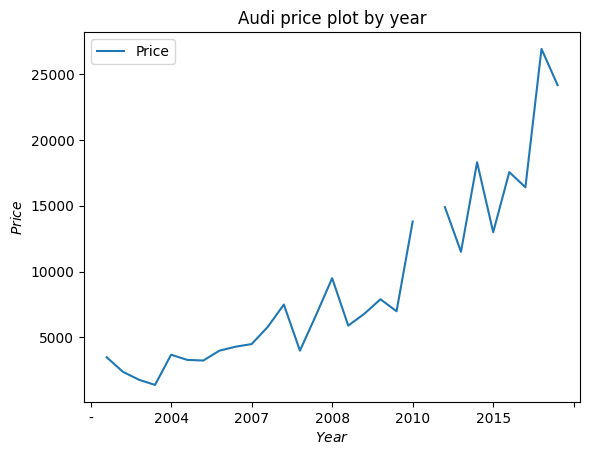

In [21]:
audi_price_plot = pd.DataFrame(audi_sorted_by_year,columns=['Year','Price'])
audi_price_plot.plot(x ='Year', y='Price', kind = 'line')
plt.legend()
plt.xlabel('$Year$')
plt.ylabel('$Price$')
plt.title('Audi price plot by year')




Text(0.5, 1.0, 'Audi model plot by car number')

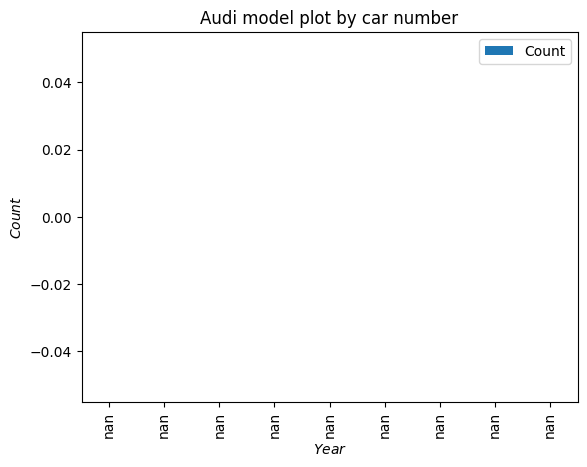

In [24]:
audi_price_plot = pd.DataFrame(audi_grouped_by_model,columns=['Model', 'Count'])
audi_price_plot.plot(x ='Model', y='Count', kind = 'bar')
plt.legend()
plt.xlabel('$Year$')
plt.ylabel('$Count$')
plt.title('Audi model plot by car number')



In [25]:
audi_df['Volume'] = audi_df['Volume'].str.replace('D', '')
audi_df.head()


,Unnamed: 0,description,url,Model,Year,Volume,Run,Price
0,0,Audi A6 S-Line Quattro 2.7 132kW\r\n\r\nАвтомо...,https://ss.com/msg/en/transport/cars/audi/a6/g...,A6,2007,2.7,318 thd.,4499.0
1,1,"Audi A6 Quattro, 3.0Tdi, automāts, melns ādas ...",https://ss.com/msg/en/transport/cars/audi/a6/b...,A6,2004,3.0,327 thd.,3690.0
2,2,"Pārdod Audi A6 C6, 2009.g. , facelift, S'line,...",https://ss.com/msg/en/transport/cars/audi/a6/a...,A6,2009,2.7,290 thd.,7900.0
3,3,Nopirksim Jūsu Audi uzreiz. Autosalons pērk vi...,https://ss.com/msg/en/transport/cars/audi/a3/k...,A3,-,-,-,NaN
4,4,Allroad Quattro. 132kw. Auto darba kārtībā. 5-...,https://ss.com/msg/en/transport/cars/audi/allr...,Allroad,2003,2.5,348 thd.,1795.0


In [26]:
audi_pivot_table = audi_df.pivot_table(index='Year', columns='Volume', values='Price', aggfunc=np.median)
audi_pivot_table

Volume,1.4,1.6,1.9,2.0,2.5,2.7,3.0
Year,,,,,,,
2001,3500.0,NaN,2400.0,NaN,NaN,NaN,NaN
2003,NaN,NaN,NaN,NaN,1597.0,NaN,NaN
2004,NaN,NaN,NaN,3299.0,NaN,NaN,3690.0
2005,NaN,NaN,NaN,3250.0,NaN,NaN,NaN
2006,NaN,NaN,NaN,4149.0,NaN,NaN,NaN
2007,NaN,NaN,NaN,NaN,NaN,4499.0,5800.0
2008,NaN,NaN,NaN,6699.0,NaN,5900.0,9500.0
2009,NaN,NaN,NaN,NaN,NaN,7350.0,6990.0
2010,NaN,NaN,NaN,NaN,NaN,NaN,13800.0
